In [19]:
import math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.core.algorithms import mode
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.python.keras.backend import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.callbacks import History
# from series_to_supervised import series_to_supervised
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

                 AP        F1         F2
0       5332.000000  4.516648  82.274611
1       5332.000000  4.405237  83.692125
2       6762.321600  4.280012  83.741625
3       7988.472733  4.156746  82.814785
4       8990.669733  4.051211  81.303281
...             ...       ...        ...
38008  11035.000000  2.335631  46.897660
38009  10574.000000  2.709179  42.584110
38010  10257.000000  2.885565  39.768022
38011  12720.000000  2.791558  39.059383
38012  13680.000000  2.353928  41.068179

[38013 rows x 3 columns]


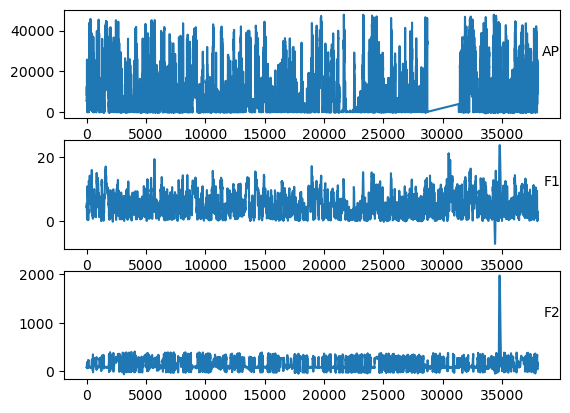

In [20]:
dataset = pd.read_csv("../result/test.csv", index_col=0) #读取数据 ‘特征一’ ‘特征二’ ‘有功’ ‘开机容量’
dataset.columns = ['F1','F2','AP','C']  #重命名表头
dataset.insert(0,'AP',dataset.pop('AP'))   #将预测项放在首列
dataset_c = dataset.pop('C')
print(dataset)
# dataset.dropna(subset = ['pm25'], inplace = True) #去掉pm25为空的行
values = dataset.values #数值特征变量
groups = [0, 1, 2]
i = 1
plt.figure() #新建画布
for group in groups:
    plt.subplot(len(groups), 1, i) #子图
    plt.plot(values[:, group]) #折线图
    plt.title(dataset.columns[group], y = 0.5, fontsize = 10, loc = "right") #取字段为子图标题
    i +=1
plt.show()

In [21]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
timesteps = 1
n_in = 20  #利用历史96个数据来参与预测
n_out= 1  #希望预测未来96个点
time_history = 61  #选取的历史数据列数
n_train_hours = 200*96 #一天24*4=96个时间点
n_test_hours= 50*96

encoder = LabelEncoder() #编码
# values[:,3] = encoder.fit_transform(values[:,3]) #将第4列编码
values = values.astype('float32') #使得所有数值类型都是float类型
values_backup = values.copy()
scaler = MinMaxScaler(feature_range = (0, 1)) #0-1归一化
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, n_in, n_out) #调用series_to_supervised函数将数据转为监督数据变成16列
# reframed.drop(reframed.columns[[60, 61, 62]], axis= 1,inplace = True) 
# print(reframed.head())
values = reframed.values
train = values[:n_train_hours, :time_history] #训练集
test = values[n_train_hours:(n_train_hours + n_test_hours), :time_history] #测试集
train_x, train_y = train[:, :-1], train[:, -1] #训练集特征和标签 
test_x, test_y = test[:, :-1], test[:, -1] #测试集的特征和标签
train_x = train_x.reshape((int(train_x.shape[0]/timesteps), timesteps, train_x.shape[1])) #转为LSTM模型的输入格式（samples, timesteps, features）
test_x = test_x.reshape((int(test_x.shape[0]/timesteps), timesteps, test_x.shape[1])) #转为LSTM模型的输入格式（samples, timesteps, features）


19200 60


c:\Users\Charles\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
c:\Users\Charles\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(96, input_shape=(1, 60))`
  """


Train on 19200 samples, validate on 4800 samples
Epoch 1/50
 - 1s - loss: 0.0701 - val_loss: 0.0289
Epoch 2/50
 - 1s - loss: 0.0400 - val_loss: 0.0229
Epoch 3/50
 - 1s - loss: 0.0352 - val_loss: 0.0305
Epoch 4/50
 - 1s - loss: 0.0326 - val_loss: 0.0312
Epoch 5/50
 - 1s - loss: 0.0318 - val_loss: 0.0232
Epoch 6/50
 - 1s - loss: 0.0298 - val_loss: 0.0216
Epoch 7/50
 - 1s - loss: 0.0311 - val_loss: 0.0384
Epoch 8/50
 - 1s - loss: 0.0305 - val_loss: 0.0263
Epoch 9/50
 - 1s - loss: 0.0296 - val_loss: 0.0200
Epoch 10/50
 - 1s - loss: 0.0267 - val_loss: 0.0174
Epoch 11/50
 - 1s - loss: 0.0292 - val_loss: 0.0221
Epoch 12/50
 - 1s - loss: 0.0268 - val_loss: 0.0221
Epoch 13/50
 - 1s - loss: 0.0278 - val_loss: 0.0308
Epoch 14/50
 - 1s - loss: 0.0262 - val_loss: 0.0176
Epoch 15/50
 - 1s - loss: 0.0248 - val_loss: 0.0181
Epoch 16/50
 - 1s - loss: 0.0276 - val_loss: 0.0174
Epoch 17/50
 - 1s - loss: 0.0270 - val_loss: 0.0172
Epoch 18/50
 - 1s - loss: 0.0260 - val_loss: 0.0178
Epoch 19/50
 - 1s - loss

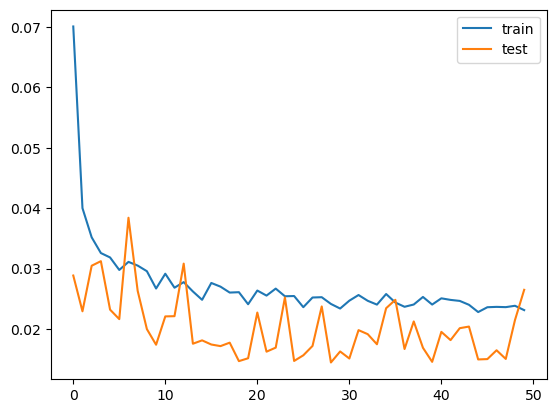

In [23]:
Bsize = 96

model = Sequential()
print(train_x.shape[0], train_x.shape[2])
model.add(LSTM(Bsize, input_length=train_x.shape[1], input_dim=train_x.shape[2])) #8760*8
model.add(Dense(1))
model.compile(loss = "mae",optimizer= "adam")
history =model.fit(train_x, train_y, batch_size=Bsize, epochs= 50, verbose=2, validation_data=(test_x, test_y), shuffle=False)
plt.figure()
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()


In [24]:
yhat = model.predict(test_x)
print(yhat)

# values0 = values_backup[:(n_train_hours + n_test_hours),0] #使得所有数值类型都是float类型
# scaler = MinMaxScaler(feature_range = (0, 1)) #0-1归一化
# scaled = scaler.fit_transform(values0.reshape(-1,1))
# inv_yhat = np.vstack([train_y.reshape(len(train_y),1), yhat])
# inv_y = np.vstack([train_y.reshape(len(train_y),1), test_y.reshape(len(test_y),1)])
# inv_yhat = scaler.inverse_transform(inv_yhat.reshape(-1,1))
# inv_y = scaler.inverse_transform(inv_y.reshape(-1,1))

values0 = values_backup[:,0] #使得所有数值类型都是float类型
max_y = max(values0)
min_y = min(values0)
inv_yhat = np.vstack([train_y.reshape(len(train_y),1), yhat])
inv_y = np.vstack([train_y.reshape(len(train_y),1), test_y.reshape(len(test_y),1)])
inv_yhat = inv_yhat * (max_y - min_y) + min_y
inv_y = inv_y * (max_y - min_y) + min_y

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("the rmse is: %.3f" %rmse)

[[0.09497055]
 [0.1031896 ]
 [0.085182  ]
 ...
 [0.57924485]
 [0.6493663 ]
 [0.64211583]]
the rmse is: 766.668


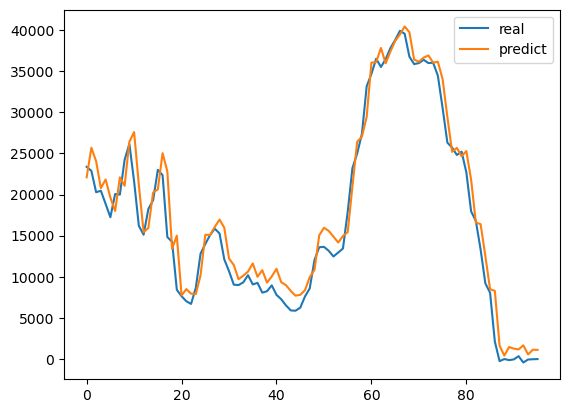

In [27]:
plt.figure()
plt.plot(inv_y[220*96:221*96], label = "real")
plt.plot(inv_yhat[220*96:221*96], label = "predict")
plt.legend()
plt.show()

In [26]:
# 指标计算
Num_unit = 66
Unit_cap = 750
MIN_operating_rate = 0.1
MIN_operating_capacity = MIN_operating_rate * Num_unit * Unit_cap

time_shift = n_in
inv_test_y = inv_y[(n_train_hours):, :]
inv_test_yhat = inv_yhat[(n_train_hours):, :]
test_cap = dataset_c[(time_shift + n_train_hours):(time_shift + n_train_hours + n_test_hours)]

#均方根误差
Er = 0.0
for real, pre, cap in zip(inv_test_y, inv_test_yhat, test_cap):
    if cap > MIN_operating_capacity:       #超过10%的风机在运行
        Er += ((real - pre) / cap) ** 2
Er /= len(inv_test_y)
Er **= 0.5
print("the Er is: %.3f" %Er)

#准确率
Cr = 1.0 - Er
print("the Cr is: %.3f" %Cr)

#合格率
Qc = 0.0
for real, pre, cap in zip(inv_test_y, inv_test_yhat, test_cap):
    if (cap > MIN_operating_capacity):
        if (abs(real-pre) / cap <= 0.25):
            Qc += 1
    else:
        Qc += 1
Qc = Qc / len(inv_test_y)
print("the Qc is: %.3f" %Qc)

the Er is: 0.080
the Cr is: 0.920
the Qc is: 0.984
